# Multiple Ring Neurons Experiment

## Imports

In [43]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import datetime as dt
import os

In [44]:
COLORS = mcolors.TABLEAU_COLORS
COLOR_NAMES = [k.replace('tab:', '') for k in COLORS.keys()]
COLORS = list(COLORS.values())

# Utilities

In [45]:
def create_frame(ax, xs, ys, t) -> None:
    '''
    :param xs list: a list of the x-values of the doodle
    :param ys list: a list of the y-values of the doodle
    :param t int: the current timestep in the doodle

    TODO file naming
    '''
    ax.plot(xs[:(t+1)], ys[:(t+1)], color = 'gray' )
    ax.plot(xs[t], ys[t], color = 'black', marker = 'o' )
    ax.set_xlim([-1, 1])
    ax.set_xlabel('x', fontsize = 14)
    ax.set_ylim([-1, 1])
    ax.set_ylabel('y', fontsize = 14)
    ax.set_title(f'Step {t}', fontsize=14)

# Model Definition

## Equations

### Equations

Activation: 

$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda u_i v_i + I_i' (1 - \alpha \sum\limits_{\substack{j \in R \\ j \ne i}}z_j));$

Input Depletion:

$\frac{dI_i'}{dt} = -\varphi I_i z_i$

Deactivation: 

$\frac{du_i}{dt}=-\rho u_i + \gamma I_i' \frac{z_i}{c_i + \epsilon};$

Output: 

$z_i=f(v_i)=\frac{1}{1+e^{-\beta (v_i - \mu)}};$

In [46]:
def sigmoid(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

## Neurons

In [47]:
NUM_UNITS = 8
directions = np.array([np.deg2rad(i * 360 / NUM_UNITS) for i in range(NUM_UNITS)]) # radians
headings = np.array([[np.cos(dir), np.sin(dir)] for dir in directions])

## Driver Code

In [48]:
def doodle(t, state, p):
    '''
    Because we can't provide a vectorized state (i.e. state can't be 2-d in solve_ivp()),
    we hide the two vectors in state, so state is a vector of [v, u], 
    where v and u are both vectors of length `num_units`.
    
    Then, we can handle the change in v and change in u separately, 
    and concat them back together to be returned as the new state.
    '''
    v = state[0:p['N']]
    u = state[p['N']:2*p['N']]
    I_prime = state[2*p['N']:]

    assert set([v.shape[0], u.shape[0], I_prime.shape[0]]) == set([p['N']]), f"State's shapes don't match! {v.shape, u.shape, I_prime.shape}"

    z = sigmoid(v, p['beta'], p['mu'])
   
    # calculate dv/dt, du/dt, DI'/dt
    inhibition_vec = 1 - (p['alpha'] * np.dot(z, 1 - np.eye(p['N']))) # multiply by the sum of *other* neuron's outputs
    dv = (1 / p['tau']) * ((-1 * p['lambda'] * u * v) + (I_prime * inhibition_vec))
    du = (-1 * p['rho'] * u) + (p['gamma'] * I_prime * (z) / (p['c'] + p['epsilon']))
    dI_prime = -1 * p['phi'] * p['I'] * z
    
    # join v and u back together to be returned
    return np.array((dv, du, dI_prime)).reshape(3*p['N'])

### Plot all variables on one plot

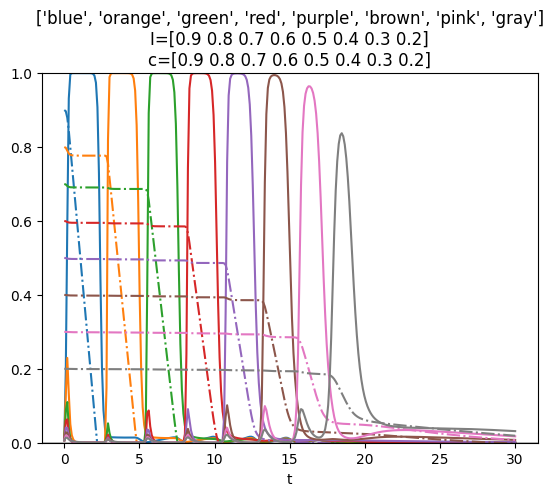

In [51]:
t_max = 30
t_steps = 300
t = np.linspace(0, t_max, t_steps)

I = np.array([0.9, 0.8, 0.7 ,0.6 , 0.5, 0.4, 0.3, 0.2])
c = np.array([0.9, 0.8, 0.7 ,0.6 , 0.5, 0.4, 0.3, 0.2])

params = {
    'N': NUM_UNITS,
    'tau': 1.0,
    'lambda': 20,
    'alpha': 1.2,
    'I': I,
    'rho': 0.1,
    'gamma': 0.1,
    'c': c,
    'epsilon': 0.00001,
    'beta': 50.0,
    'mu': 0.1,
    'phi': 0.5
}


v = np.zeros(params['N'])
u = np.zeros(params['N'])

state = np.array((v, u, I)).reshape(3*params['N'])
result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(min(t), max(t)), t_eval=t, y0=state)
v_series = result.y[:params['N'],]
z_series = sigmoid(v_series, params['beta'], params['mu'])
u_series = result.y[params['N']:2*params['N'],]
I_prime_series = result.y[2*params['N']:,]

fig, axs = plt.subplots()
for i in range(params['N']):
    color = COLORS[i]
    # plt.plot(t, v_series[i], label=f'v_{i}', c=color, linestyle='dashed')
    # plt.plot(t, u_series[i], label=f'u_{i}', c=color, linestyle='dotted')
    plt.plot(t, z_series[i], label=f'z_{i}', c=color, linestyle='solid')
    plt.plot(t, I_prime_series[i], label=f"I'_{i}", c=color, linestyle='dashdot')
    plt.axhline(y=0.0, c="black", linewidth=0.05)

# plt.legend()
plt.ylim([0, 1])
plt.xlabel('t')
plt.title(f'{COLOR_NAMES[:params["N"]]}\nI={I}\nc={np.round(c, 2)}')

graph_ax = axs

# draw output
dir_series = z_series.T @ headings
xs = (1 / t_steps) * dir_series[:,0]
ys = (1 / t_steps) * dir_series[:,1]

x_series = np.cumsum(xs)
y_series = np.cumsum(ys)

# create GIF
if not os.path.isdir('img'):
    os.mkdir(f'.\\img')

frames = []
for t in range(t_steps):
    f, axs = plt.subplots(1, 2)
    axs[0] = graph_ax

    create_frame(axs[1], x_series, y_series, t)
    f.savefig(f'.\\img\\img_{t}.png')
    plt.close()
    image = imageio.v2.imread(f'.\\img\\img_{t}.png')
    frames.append(image)

imageio.mimsave('example.gif', frames, duration=t_max)